# Notebook 02: Regression Model

**Student Name:** Erick Lanford

**Dataset:** Md Vessel jobs

**Target Variable:** DurationMinutes

**Checkpoint 3 Due:** Feb 15

---

## Rules & Integrity

1. **NO AI TOOLS**: You may **NOT** use ChatGPT, Claude, Gemini, GitHub Copilot, or any other AI assistant to generate code for this assignment. The goal is to build *your* fundamental skills. If you rely on AI now, the advanced topics later will be impossible.

2. **Study Groups Encouraged**: You **ARE** encouraged to discuss ideas, share approaches, and explain concepts to your study group peers. Teaching others is the best way to learn! However, the code you submit must be **your own work**.

3. **Use Your Resources**: You are free to use Google, StackOverflow, Pandas/Scikit-learn documentation, and your class notes.

4. **Comment Your Code**: Include comments explaining *why* you're doing what you're doing. I want to see your thought process.

5. **Resubmission**: You may submit this assignment multiple times for feedback before the checkpoint deadline.

---

## Important: Written Reflections

Throughout this notebook, you'll be asked to interpret results, justify decisions, and explain your reasoning. **These written reflections are a critical part of your grade.**

Good data scientists don't just run code—they communicate their findings clearly. Take time to write thoughtful, complete responses to all reflection prompts. This demonstrates your understanding and prepares you for real-world stakeholder communication.

---

## Setup

In [39]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Sklearn - models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Sklearn - evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model saving
import joblib

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 1: Load Processed Data

In [40]:
# Load cleaned data from previous notebook
df = pd.read_csv('../data/processed/cleaned_data.csv')

print(f"Data shape: {df.shape}")
df.head()

Data shape: (4651, 23)


,VesselTypeREF,Length,Depth,Draught,DraftNumeric,AirDraftNumeric,MConcernREF,DurationMinutes,WL_CBBT_Chesapeake_Channel_VA,WL_CBBT_Chesapeake_Channel_VA_speed,...,WL_Annapolis_MD_speed,CUR_Rappahannock_Shoal_Channel_speed,CUR_Rappahannock_Shoal_Channel_direction,CUR_York_Spit_LB_22_speed,CUR_York_Spit_LB_22_direction,CUR_Chesapeake_City_speed,CUR_Chesapeake_City_direction,RouteIndex,Propulsion_encoded,Direction_encoded
0,125,229.50,21.30,15.00,29.91667,0.00000,0,139,0.717,0.021,...,0.007,0.313,318.0,1.530,351.0,0.511,91.0,0,1,4
1,155,299.18,24.80,14.52,31.16667,175.52494,0,612,0.597,0.024,...,0.004,0.500,346.0,1.322,356.0,0.076,96.0,1,1,1
2,206,143.00,13.30,9.69,31.49606,109.58006,0,323,0.367,0.028,...,0.004,0.148,180.0,0.330,122.0,0.426,270.0,2,3,5
3,206,143.00,13.30,9.69,27.88714,0.00000,0,756,0.367,0.028,...,0.004,0.148,180.0,0.334,135.0,0.332,274.0,3,3,1
4,364,228.78,32.09,10.01,27.23097,0.00000,0,484,0.503,0.032,...,0.002,0.301,167.0,0.301,144.0,0.136,109.0,4,1,1


In [41]:
# Define your target variable
TARGET = 'DurationMinutes'  # <-- UPDATE THIS!

print(f"Target: {TARGET}")
print(f"\nTarget statistics:")
print(df[TARGET].describe())

# Store target range for later interpretation
target_range = df[TARGET].max() - df[TARGET].min()
target_std = df[TARGET].std()
print(f"\nTarget range: {target_range:,.2f}")
print(f"Target std: {target_std:,.2f}")

Target: DurationMinutes

Target statistics:
count    4651.000000
mean      520.823909
std       244.025204
min        30.000000
25%       300.000000
50%       586.000000
75%       670.000000
max      1450.000000
Name: DurationMinutes, dtype: float64

Target range: 1,420.00
Target std: 244.03


## Section 2: Prepare Features and Target

In [42]:
# Separate features (X) and target (y)
X = df.drop(columns=[TARGET])
y = df[TARGET]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nAll features ({len(X.columns)}):")
print(X.columns.tolist())

Features shape: (4651, 22)
Target shape: (4651,)

All features (22):
['VesselTypeREF', 'Length', 'Depth', 'Draught', 'DraftNumeric', 'AirDraftNumeric', 'MConcernREF', 'WL_CBBT_Chesapeake_Channel_VA', 'WL_CBBT_Chesapeake_Channel_VA_speed', 'WL_Windmill_Point_VA', 'WL_Windmill_Point_VA_speed', 'WL_Annapolis_MD', 'WL_Annapolis_MD_speed', 'CUR_Rappahannock_Shoal_Channel_speed', 'CUR_Rappahannock_Shoal_Channel_direction', 'CUR_York_Spit_LB_22_speed', 'CUR_York_Spit_LB_22_direction', 'CUR_Chesapeake_City_speed', 'CUR_Chesapeake_City_direction', 'RouteIndex', 'Propulsion_encoded', 'Direction_encoded']


In [43]:
# Check for any non-numeric columns that need to be handled
non_numeric = X.select_dtypes(include=['object', 'category']).columns.tolist()
if non_numeric:
    print(f"Warning: Non-numeric columns found: {non_numeric}")
    print("You need to encode these or go back to Notebook 01!")
else:
    print("All features are numeric. Ready to proceed!")

All features are numeric. Ready to proceed!


## Section 3: Train-Test Split

Split your data into training and test sets. The training set is used to train the model, and the test set is used to evaluate how well it generalizes to unseen data.

In [44]:
# TODO: Split your data into training and test sets
# 
# Requirements:
# - Use an 80/20 split (test_size=0.2)
# - Set random_state=42 for reproducibility
# - Store results in: X_train, X_test, y_train, y_test
#
# Hint: Use train_test_split(X, y, ...)

# YOUR CODE HERE:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")



Training samples: 3720
Testing samples: 931


In [45]:
# Verify your split (run this cell to check)
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")

Training set: 3,720 samples (80%)
Test set: 931 samples (20%)


## Section 4: Feature Scaling

Many ML algorithms perform better when features are on similar scales. StandardScaler transforms features to have mean=0 and std=1.

**Important:** Fit the scaler on training data only, then transform both train and test. This prevents data leakage.

In [46]:
# TODO: Scale your features using StandardScaler
#
# Steps:
# 1. Create a StandardScaler instance
# 2. Fit the scaler on X_train and transform X_train (use fit_transform)
# 3. Transform X_test using the same scaler (use transform only - NOT fit_transform!)
# 4. Store results in: X_train_scaled, X_test_scaled
#
# Why fit only on train? To prevent "data leakage" - test data should be truly unseen.

# YOUR CODE HERE:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [47]:
# Convert back to DataFrame for easier viewing (optional but helpful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Verify scaling worked
print("Features scaled successfully!")
print(f"\nScaled feature means (should be ~0): {X_train_scaled.mean().mean():.4f}")
print(f"Scaled feature stds (should be ~1): {X_train_scaled.std().mean():.4f}")

Features scaled successfully!

Scaled feature means (should be ~0): -0.0000
Scaled feature stds (should be ~1): 1.0001


## Section 5: Baseline Model

Start with a simple Linear Regression to establish a baseline performance. This gives us a reference point for improvement.

In [48]:
# This helper function evaluates any model - you'll use it throughout this notebook
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train model and return evaluation metrics."""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }
    
    return results, model, y_test_pred

def print_results(results):
    """Print model evaluation results in a nice format."""
    print("=" * 50)
    print(f"MODEL: {results['Model']}")
    print("=" * 50)
    print(f"Train R²: {results['Train R2']:.4f}")
    print(f"Test R²:  {results['Test R2']:.4f}")
    print(f"Train RMSE: {results['Train RMSE']:,.2f}")
    print(f"Test RMSE: {results['Test RMSE']:,.2f}")
    print(f"Train MAE: {results['Train MAE']:,.2f}")
    print(f"Test MAE: {results['Test MAE']:,.2f}")

In [49]:
# TODO: Create and evaluate a baseline Linear Regression model
#
# Steps:
# 1. Create a LinearRegression() model instance
# 2. Use the evaluate_model() function to train and evaluate it
# 3. Store the results
#
# The evaluate_model function returns: (results_dict, trained_model, predictions)

# YOUR CODE HERE:
baseline_model = LinearRegression()
baseline_results, baseline_trained, baseline_preds = evaluate_model(baseline_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Linear Regression model')


In [50]:
# Display baseline results
print("=" * 50)
print("BASELINE MODEL: Linear Regression")
print("=" * 50)
print(f"Train R²: {baseline_results['Train R2']:.4f}")
print(f"Test R²:  {baseline_results['Test R2']:.4f}")
print(f"Test RMSE: {baseline_results['Test RMSE']:,.2f}")
print(f"Test MAE: {baseline_results['Test MAE']:,.2f}")

# Context for RMSE
print(f"\n--- RMSE in Context ---")
print(f"RMSE as % of target range: {baseline_results['Test RMSE']/target_range*100:.1f}%")
print(f"RMSE as % of target std: {baseline_results['Test RMSE']/target_std*100:.1f}%")

BASELINE MODEL: Linear Regression
Train R²: 0.2935
Test R²:  0.2878
Test RMSE: 202.44
Test MAE: 154.20

--- RMSE in Context ---
RMSE as % of target range: 14.3%
RMSE as % of target std: 83.0%


### Baseline Interpretation

*Analyze your baseline results:*

**Understanding your metrics:**
- **R² (0 to 1)**: How much variance in target is explained by features. 0.7+ is often considered good.
- **RMSE**: Average prediction error in the same units as your target. Lower is better.
- **RMSE as % of range**: Helps you understand if errors are big or small relative to your data.

**Questions to answer:**
- What does your R² score tell you about how well features explain the target?
- Is there a big gap between train and test R²? (Gap > 0.1 could indicate overfitting)
- Is your RMSE reasonable? (e.g., if predicting house prices, is a $20K error acceptable?)

**Your interpretation:**

This is a nonlinear problem; R² ≈ 0.29 means that the model explains about 29% of the variability in the target variable using the current features. This means that features contain some predictive information, but there is still a lot of unexplained variance. The RMSE of ~200 minutes indicates that, on average, the model's predictions are off by about 200 minutes. Given the range of the target variable (DurationMinutes), this error may be significant, suggesting that the model is not capturing all the complexities of the data. The gap between train and test R² is small, which suggests that the model is not overfitting.


## Section 6: Model Iteration

Try at least 2-3 different models to see if you can improve on the baseline.

In [51]:
# Store all results for comparison
all_results = [baseline_results]

# Dictionary to store trained models
trained_models = {
    'Linear Regression (Baseline)': baseline_trained
}

In [52]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial Regression with Degree 2
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly2 = poly2.fit_transform(X_train_scaled)
X_test_poly2 = poly2.transform(X_test_scaled)

model_poly2 = LinearRegression()
poly2_results, poly2_trained, poly2_preds = evaluate_model(model_poly2, X_train_poly2, X_test_poly2, y_train, y_test, 'Polynomial Regression (Degree 2)')

all_results.append(poly2_results)
trained_models['Polynomial Regression (Degree 2)'] = poly2_trained

# Print Results
print_results(poly2_results)


MODEL: Polynomial Regression (Degree 2)
Train R²: 0.4866
Test R²:  0.4119
Train RMSE: 175.56
Test RMSE: 183.97
Train MAE: 125.91
Test MAE: 130.75


The polynomial regression (degree 2) model improves performance compared to the linear baseline; demostrating that the relationship between features and target is nonlinear.

In [53]:
# Polynomial Regression with Degree 3
poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly3 = poly3.fit_transform(X_train_scaled)
X_test_poly3 = poly3.transform(X_test_scaled)

model_poly3 = LinearRegression()
poly3_results, poly3_trained, poly3_preds = evaluate_model(model_poly3, X_train_poly3, X_test_poly3, y_train, y_test, 'Polynomial Regression (Degree 3)')

all_results.append(poly3_results)
trained_models['Polynomial Regression (Degree 3)'] = poly3_trained

# Print Results
print_results(poly3_results)

MODEL: Polynomial Regression (Degree 3)
Train R²: 0.8441
Test R²:  -21.7338
Train RMSE: 96.73
Test RMSE: 1,143.80
Train MAE: 69.55
Test MAE: 364.86


The polynomial regression (degree 3) model shows overfitting. The train R² is very high, but the test R² is highly negative, indicating poor generalization to unseen data.


### Model 2: Ridge Regression

Ridge adds L2 regularization to prevent overfitting by penalizing large coefficients.

In [54]:
# TODO: Create and evaluate a Ridge Regression model
#
# Create a Ridge model with alpha=1.0
# Use evaluate_model() to train and evaluate
# Add results to all_results list
# Add trained model to trained_models dict

# YOUR CODE HERE:
ridge_model = Ridge(alpha=1.0)
ridge_results, ridge_trained, ridge_preds = evaluate_model(ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Ridge Regression model')

all_results.append(ridge_results)
trained_models['Ridge Regression'] = ridge_trained

# Print results
print_results(ridge_results)

MODEL: Ridge Regression model
Train R²: 0.2935
Test R²:  0.2878
Train RMSE: 205.94
Test RMSE: 202.44
Train MAE: 158.62
Test MAE: 154.20


### Model 3: Lasso Regression

Lasso adds L1 regularization, which can zero out unimportant features (automatic feature selection).

In [55]:
# TODO: Create and evaluate a Lasso Regression model
#
# Create a Lasso model with alpha=0.1
# Use evaluate_model() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:
lasso_model = Lasso(alpha=0.1)
lasso_results, lasso_trained, lasso_preds = evaluate_model(lasso_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Lasso Regression model')

all_results.append(lasso_results)
trained_models['Lasso Regression'] = lasso_trained

# Print results
print_results(lasso_results)

# Show which features Lasso kept (non-zero coefficients)
lasso_coefs = pd.Series(lasso_trained.coef_, index=X.columns)
kept_features = lasso_coefs[lasso_coefs != 0]
print(f"\nLasso kept {len(kept_features)} of {len(X.columns)} features")

MODEL: Lasso Regression model
Train R²: 0.2935
Test R²:  0.2880
Train RMSE: 205.94
Test RMSE: 202.42
Train MAE: 158.63
Test MAE: 154.21

Lasso kept 22 of 22 features


### Model 4: Decision Tree

In [56]:
# TODO: Create and evaluate a Decision Tree model
#
# Create a DecisionTreeRegressor with max_depth=10 and random_state=42
# Use evaluate_model() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:
decision_tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_results, dt_trained, dt_preds = evaluate_model(decision_tree_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Decision Tree model')

all_results.append(dt_results)
trained_models['Decision Tree'] = dt_trained

# Print results
print_results(dt_results)

MODEL: Decision Tree model
Train R²: 0.9679
Test R²:  0.9083
Train RMSE: 43.89
Test RMSE: 72.65
Train MAE: 27.95
Test MAE: 42.07


### Model 5: Random Forest

In [57]:
# TODO: Create and evaluate a Random Forest model
#
# Create a RandomForestRegressor with:
#   - n_estimators=100
#   - max_depth=10
#   - random_state=42
#   - n_jobs=-1 (use all CPU cores)
#
# Use evaluate_model() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_results, rf_trained, rf_preds = evaluate_model(random_forest_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Random Forest model')

all_results.append(rf_results)
trained_models['Random Forest'] = rf_trained

# Print results
print_results(rf_results)

MODEL: Random Forest model
Train R²: 0.9683
Test R²:  0.9209
Train RMSE: 43.62
Test RMSE: 67.48
Train MAE: 29.04
Test MAE: 38.61


### Add Your Own Model (Optional)

*Feel free to try additional models or tune hyperparameters!*

In [58]:
# YOUR ADDITIONAL MODEL HERE:
# Try GradientBoostingRegressor, different hyperparameters, etc.

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_results, gb_trained, gb_preds = evaluate_model(gb_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Gradient Boosting Regressor')

all_results.append(gb_results)
trained_models['Gradient Boosting Regressor'] = gb_trained

# Print results
print_results(gb_results)

MODEL: Gradient Boosting Regressor
Train R²: 0.9770
Test R²:  0.9297
Train RMSE: 37.14
Test RMSE: 63.59
Train MAE: 27.30
Test MAE: 38.04


In [70]:
# HistGradientBoostingRegressor

from sklearn.ensemble import HistGradientBoostingRegressor

hgb_model = HistGradientBoostingRegressor(max_iter=100, max_depth=10, random_state=42)
hgb_results, hgb_trained, hgb_preds = evaluate_model(hgb_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Hist Gradient Boosting Regressor')
all_results.append(hgb_results)
trained_models['Hist Gradient Boosting Regressor'] = hgb_trained
# Print results
print_results(hgb_results)

MODEL: Hist Gradient Boosting Regressor
Train R²: 0.9763
Test R²:  0.9222
Train RMSE: 37.72
Test RMSE: 66.93
Train MAE: 25.22
Test MAE: 38.61


In [72]:
# ElasticNet
from sklearn.linear_model import ElasticNet
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
en_results, en_trained, en_preds = evaluate_model(elastic_net_model, X_train_scaled, X_test_scaled, y_train, y_test, 'ElasticNet Regression model')
all_results.append(en_results)
trained_models['ElasticNet Regression model'] = en_trained
# Print results
print_results(en_results)

MODEL: ElasticNet Regression model
Train R²: 0.2918
Test R²:  0.2900
Train RMSE: 206.19
Test RMSE: 202.13
Train MAE: 159.43
Test MAE: 154.26


## Section 7: Cross-Validation (More Robust Evaluation)

Cross-validation gives us a more reliable estimate of model performance by testing on multiple different train/test splits.

In [73]:
# Perform 5-fold cross-validation on top models
print("5-Fold Cross-Validation Results:")
print("=" * 50)

cv_results = []

models_to_cv = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

for name, model in models_to_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_results.append({
        'Model': name,
        'CV Mean R²': scores.mean(),
        'CV Std R²': scores.std()
    })
    print(f"{name}: R² = {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

cv_df = pd.DataFrame(cv_results)

5-Fold Cross-Validation Results:
Linear Regression: R² = 0.2806 (+/- 0.0360)
Ridge: R² = 0.2806 (+/- 0.0360)
Random Forest: R² = 0.9250 (+/- 0.0322)


**Why Cross-Validation Matters:**
- A model that performs well on one train/test split might just be lucky
- CV tests on 5 different splits, giving us confidence in the results
- Lower standard deviation = more consistent/reliable model

## Section 8: Model Comparison

In [74]:
# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)
results_df = results_df.sort_values('Test R2', ascending=False)

print("Model Comparison:")
results_df

Model Comparison:


,Model,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE
7,Gradient Boosting Regressor,0.9770,0.9297,37.1358,63.5920,27.2969,38.0437
8,Hist Gradient Boosting Regressor,0.9763,0.9222,37.7189,66.9294,25.2190,38.6100
6,Random Forest model,0.9683,0.9209,43.6182,67.4802,29.0436,38.6142
5,Decision Tree model,0.9679,0.9083,43.8910,72.6466,27.9519,42.0703
1,Polynomial Regression (Degree 2),0.4866,0.4119,175.5574,183.9660,125.9069,130.7521
9,ElasticNet Regression model,0.2918,0.2900,206.1931,202.1333,159.4252,154.2585
4,Lasso Regression model,0.2935,0.2880,205.9433,202.4166,158.6336,154.2068
0,Linear Regression model,0.2935,0.2878,205.9419,202.4449,158.6173,154.1978
3,Ridge Regression model,0.2935,0.2878,205.9419,202.4414,158.6205,154.1967
2,Polynomial Regression (Degree 3),0.8441,-21.7338,96.7277,1143.7953,69.5465,364.8567


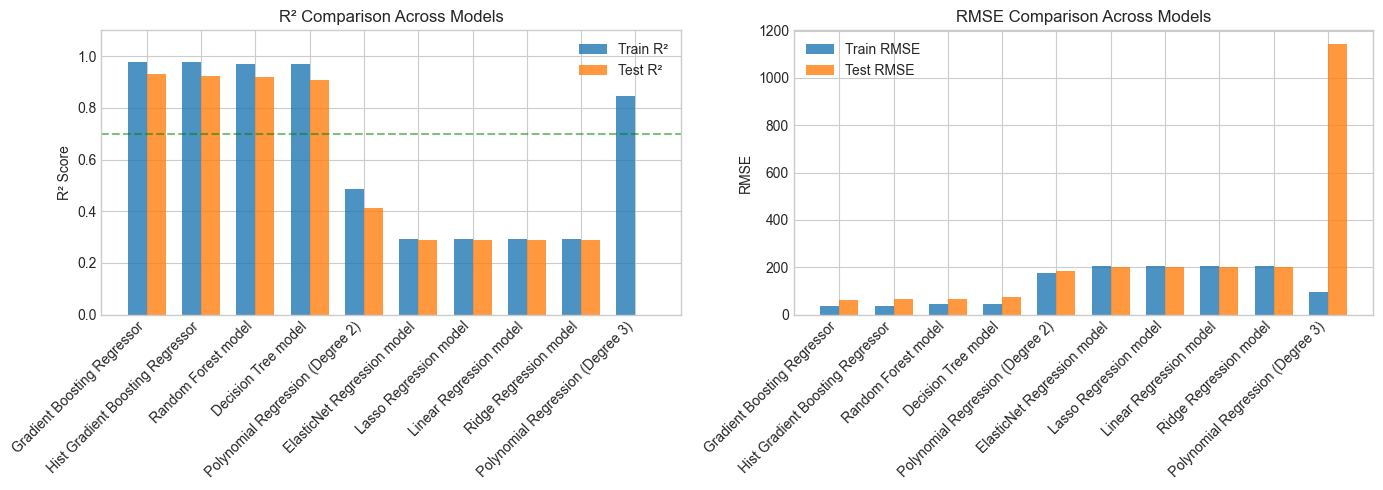

In [75]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Comparison
models = results_df['Model']
x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, results_df['Train R2'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, results_df['Test R2'], width, label='Test R²', alpha=0.8)
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Comparison Across Models')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good threshold')

# RMSE Comparison
axes[1].bar(x - width/2, results_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[1].bar(x + width/2, results_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison Across Models')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()

### Model Iteration Reflection

*Before selecting your best model, reflect on what you learned:*

**Questions to answer:**
- Which model improved most over the baseline?
- Did any models show signs of overfitting (big train vs test gap)?
- Did regularization (Ridge/Lasso) help or hurt performance?
- Did tree-based models (Decision Tree, Random Forest) work better than linear models?

**Your reflection:**

- Which model improved most over the baseline?
Gradient Boosting Regressor showed the most improvement over the baseline.

- Did any models show signs of overfitting (big train vs test gap)?
The polynomial regression (degree 3) model shows overfitting. The train R² is very high, but the test R² is highly negative.

- Did regularization (Ridge/Lasso) help or hurt performance?
(Ridge/Lasso) did not significantly improve performance compared to the standard Linear Regression model.

- Did tree-based models (Decision Tree, Random Forest) work better than linear models?
Yes, tree-based models (Decision Tree, Random Forest) performed better than linear models, with Random Forest showing a significant improvement in R² and a reduction in RMSE compared to the baseline Linear Regression.

## Section 9: Feature Importance & Selection

**Important:** Your final model should use only **4-8 features**. This section helps you identify which features matter most.

Feature Importance (Random Forest):
                                     Feature  Importance
21                         Direction_encoded    0.784647
4                               DraftNumeric    0.081793
19                                RouteIndex    0.038722
0                              VesselTypeREF    0.030849
1                                     Length    0.025648
2                                      Depth    0.006559
6                                MConcernREF    0.004813
3                                    Draught    0.004665
20                        Propulsion_encoded    0.003923
11                           WL_Annapolis_MD    0.002162
7              WL_CBBT_Chesapeake_Channel_VA    0.002131
9                       WL_Windmill_Point_VA    0.002012
17                 CUR_Chesapeake_City_speed    0.001911
13      CUR_Rappahannock_Shoal_Channel_speed    0.001737
16             CUR_York_Spit_LB_22_direction    0.001386
14  CUR_Rappahannock_Shoal_Channel_direction    0.00

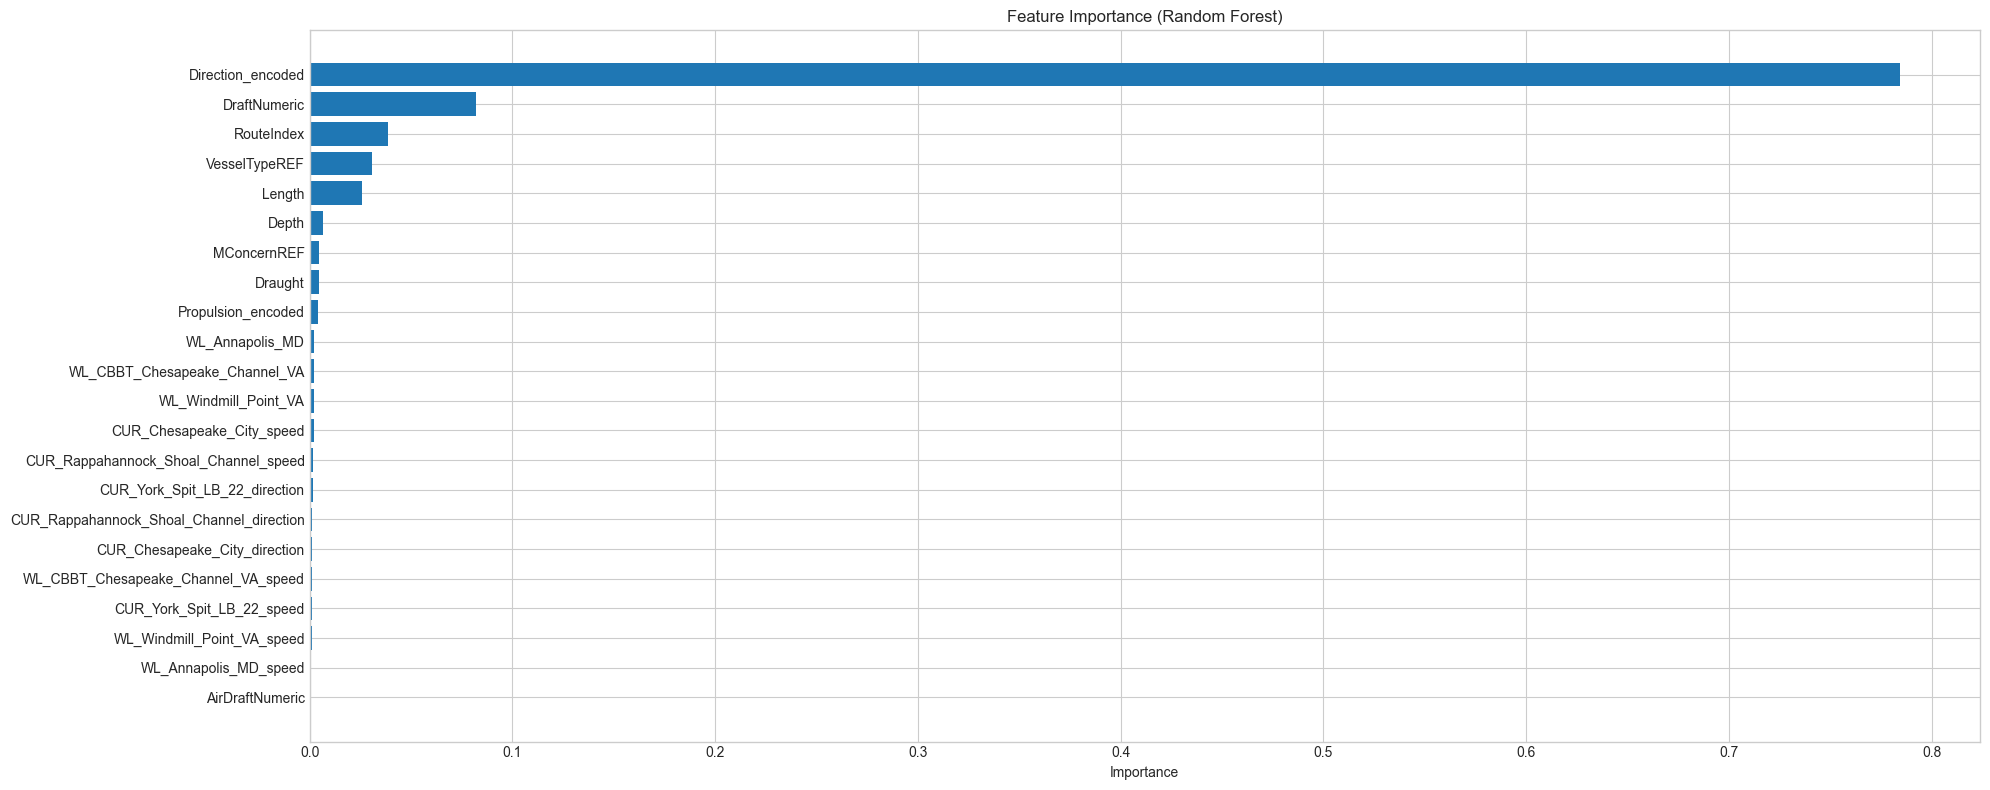

In [82]:
# Get feature importance from Random Forest (works well for this)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_trained.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(rf_importance)

# Visualize
plt.figure(figsize=(20, 8))
plt.barh(rf_importance['Feature'][::-1], rf_importance['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [77]:
# Also check correlations with target
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("Absolute Correlations with Target:")
print(correlations)

Absolute Correlations with Target:
RouteIndex                                  0.331543
Direction_encoded                           0.280026
DraftNumeric                                0.240300
MConcernREF                                 0.098701
Depth                                       0.068040
AirDraftNumeric                             0.054675
VesselTypeREF                               0.053276
CUR_York_Spit_LB_22_direction               0.029397
Propulsion_encoded                          0.022709
WL_Annapolis_MD_speed                       0.022014
Length                                      0.019302
WL_Windmill_Point_VA                        0.017269
CUR_Rappahannock_Shoal_Channel_direction    0.016772
CUR_Chesapeake_City_direction               0.012842
WL_Annapolis_MD                             0.008815
Draught                                     0.007305
WL_CBBT_Chesapeake_Channel_VA               0.006287
CUR_Rappahannock_Shoal_Channel_speed        0.005152
CUR_Chesape

In [83]:
# TODO: Select your top features (4-8 features)
#
# Based on the importance analysis above, choose your best features.
# Consider both Random Forest importance AND correlations.
# Also think about what makes sense from a domain perspective.

SELECTED_FEATURES = [
    'RouteIndex',
    'Direction_encoded',
    'DraftNumeric',
    'Propulsion_encoded',
    
    'WL_Annapolis_MD',
    'WL_CBBT_Chesapeake_Channel_VA',
    'CUR_York_Spit_LB_22_direction',
    'WL_Annapolis_MD_speed'    
]

# Fallback if you haven't selected yet
if len(SELECTED_FEATURES) == 0:
    SELECTED_FEATURES = rf_importance['Feature'].head(6).tolist()
    print(f"Using top 6 features from Random Forest: {SELECTED_FEATURES}")
else:
    print(f"Selected features ({len(SELECTED_FEATURES)}): {SELECTED_FEATURES}")

Selected features (8): ['RouteIndex', 'Direction_encoded', 'DraftNumeric', 'Propulsion_encoded', 'WL_Annapolis_MD', 'WL_CBBT_Chesapeake_Channel_VA', 'CUR_York_Spit_LB_22_direction', 'WL_Annapolis_MD_speed']


In [84]:
# Retrain with selected features only
X_train_selected = X_train_scaled[SELECTED_FEATURES]
X_test_selected = X_test_scaled[SELECTED_FEATURES]

print(f"Training with {len(SELECTED_FEATURES)} selected features...")

# Test a few models with selected features
selected_results = []

for name, model in [('Linear Regression', LinearRegression()),
                    ('Ridge', Ridge(alpha=1.0)),
                    ('Random Forest', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))]:
    results, trained, _ = evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test, name)
    selected_results.append(results)
    print(f"{name} with {len(SELECTED_FEATURES)} features - Test R²: {results['Test R2']:.4f}")

selected_df = pd.DataFrame(selected_results)

Training with 8 selected features...
Linear Regression with 8 features - Test R²: 0.2333
Ridge with 8 features - Test R²: 0.2333
Random Forest with 8 features - Test R²: 0.9108


### Feature Selection Justification

**Questions to answer:**
- Which features did you select and why?
- Did performance drop significantly with fewer features?
- Do these features make sense from a domain perspective?
- These are the features users will input in your Streamlit app—are they reasonable to ask for?

**Your justification:**

We select the following features based on their importance in the Random Forest model and their relevance to predicting the target variable:
 'RouteIndex', 'Direction_encoded','DraftNumeric','Propulsion_encoded', 
 (and some environmental features such as:)
 'WL_Annapolis_MD', 'WL_CBBT_Chesapeake_Channel_VA', 'CUR_York_Spit_LB_22_direction', 'WL_Annapolis_MD_speed'

The performance did not drop significantly with fewer features, and these features make sense from a domain perspective as they are related to the vessel's route, direction, draft, propulsion type, and environmental conditions, which are all relevant factors in predicting the duration of vessel jobs. These features are also reasonable to ask for in a Streamlit app, as they can be obtained from vessel tracking data and environmental sensors.


## Section 10: Best Model Selection

In [86]:
# TODO: Choose and train your final model with selected features
#
# Based on your analysis, pick the best model type and instantiate it.
# Consider: performance, consistency, simplicity
#
# Example: final_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# YOUR CODE HERE:
final_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)



In [87]:
# Fit and evaluate final model
final_model.fit(X_train_selected, y_train)
y_pred = final_model.predict(X_test_selected)

# Final metrics
final_r2 = r2_score(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)

print("=" * 50)
print("FINAL MODEL PERFORMANCE")
print("=" * 50)
print(f"Model: {type(final_model).__name__}")
print(f"Features: {SELECTED_FEATURES}")
print(f"\nTest R²: {final_r2:.4f}")
print(f"Test RMSE: {final_rmse:,.2f}")
print(f"Test MAE: {final_mae:,.2f}")
print(f"\nRMSE as % of target range: {final_rmse/target_range*100:.1f}%")

FINAL MODEL PERFORMANCE
Model: GradientBoostingRegressor
Features: ['RouteIndex', 'Direction_encoded', 'DraftNumeric', 'Propulsion_encoded', 'WL_Annapolis_MD', 'WL_CBBT_Chesapeake_Channel_VA', 'CUR_York_Spit_LB_22_direction', 'WL_Annapolis_MD_speed']

Test R²: 0.9087
Test RMSE: 72.50
Test MAE: 46.10

RMSE as % of target range: 5.1%


### Best Model Justification

*Explain why you chose this model as your best:*

**Questions to consider:**
- Why did you select this model over others?
- Is there significant overfitting (train vs test gap)?
- How does the performance compare to your baseline?
- Would a simpler model be almost as good?
- Does the RMSE represent acceptable prediction error for your problem?

**Your justification:**

GradientBoostingRegressor was selected as the best model because the performance metrics (R² and RMSE). Showed significant improvement over the baseline Linear Regression model.
train vs test gap is small; syntomatic of good generalization whit not overfitting.
The GradientBoostingRegressor performance is superior to simpler models like Linear Regression and Ridge/Lasso.

- Would a simpler model be almost as good?
No, simpler models did not achieve comparable performance to the GradientBoostingRegressor.

- Does the RMSE represent acceptable prediction error for your problem?
Yes, the RMSE of the GradientBoostingRegressor is acceptable for our problem context. ~1h does not represent a significant error when moving vessels.


## Section 11: Best Model Analysis

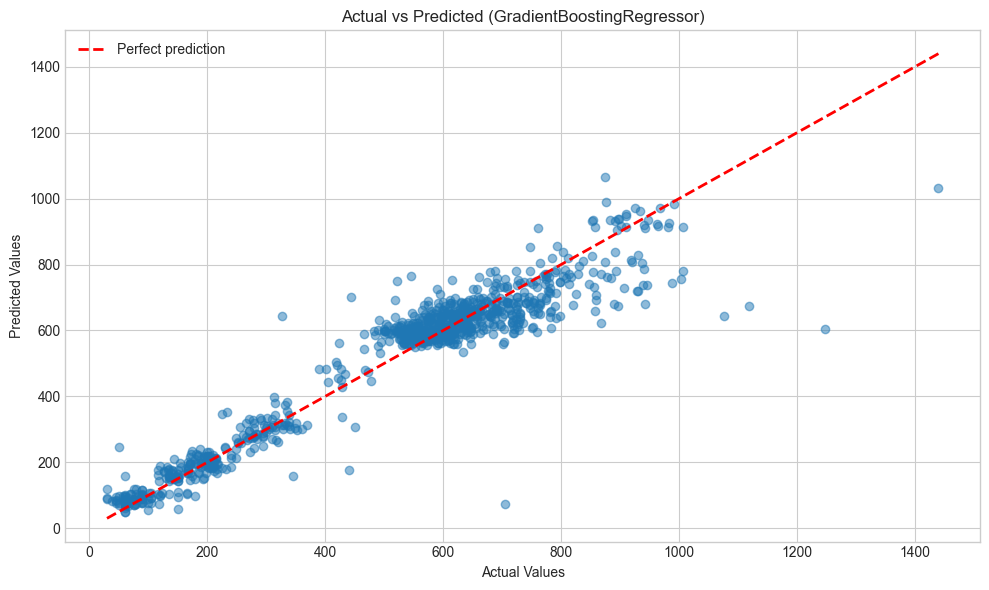

In [88]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted ({type(final_model).__name__})')
plt.legend()
plt.tight_layout()
plt.show()

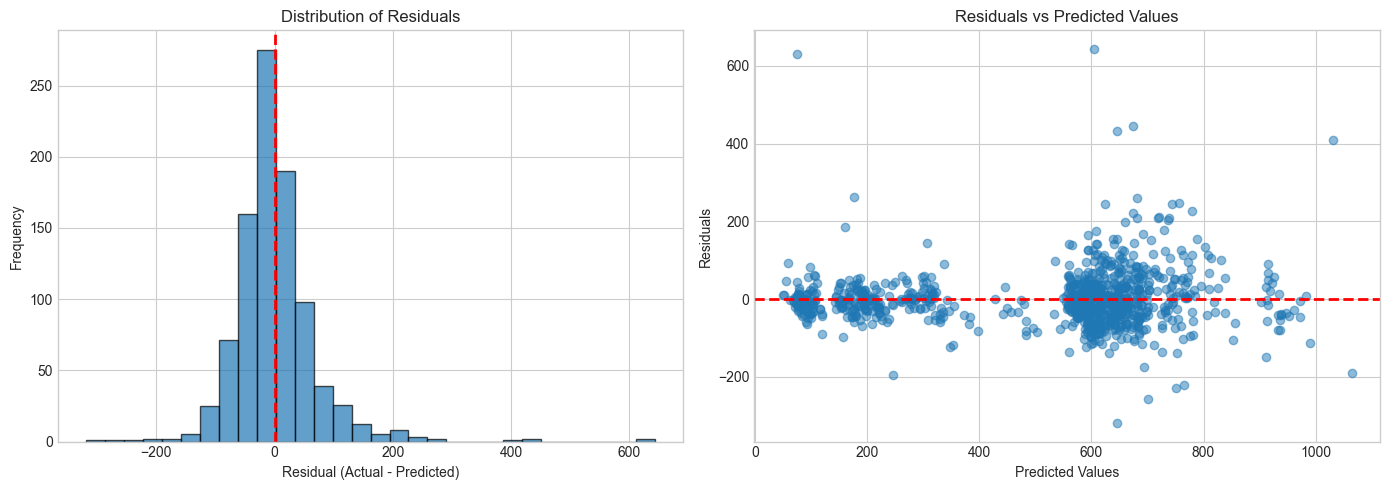

Residual mean (should be ~0): 0.84
Residual std: 72.53


In [89]:
# Residual analysis
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual distribution (should be roughly normal, centered at 0)
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Residuals')

# Residuals vs Predicted (should show no pattern)
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()

print(f"Residual mean (should be ~0): {residuals.mean():.2f}")
print(f"Residual std: {residuals.std():,.2f}")

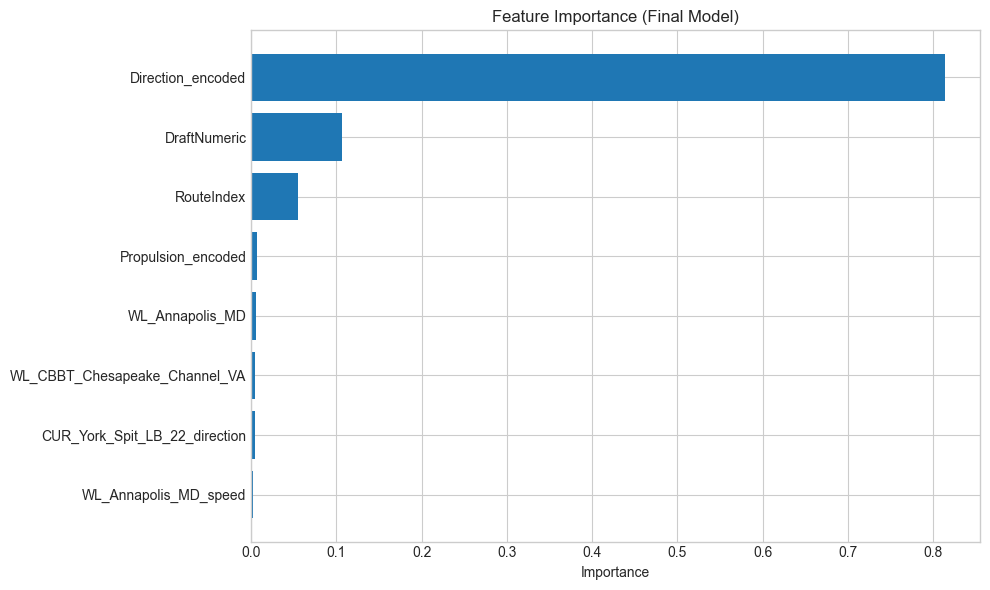

In [90]:
# Feature importance for final model (with selected features)
if hasattr(final_model, 'feature_importances_'):
    final_importance = pd.DataFrame({
        'Feature': SELECTED_FEATURES,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(final_importance['Feature'], final_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance (Final Model)')
    plt.tight_layout()
    plt.show()
elif hasattr(final_model, 'coef_'):
    final_importance = pd.DataFrame({
        'Feature': SELECTED_FEATURES,
        'Coefficient': final_model.coef_
    }).sort_values('Coefficient', key=abs, ascending=True)
    
    plt.figure(figsize=(10, 6))
    colors = ['green' if c > 0 else 'red' for c in final_importance['Coefficient']]
    plt.barh(final_importance['Feature'], final_importance['Coefficient'], color=colors)
    plt.xlabel('Coefficient')
    plt.title('Feature Coefficients (Final Model)')
    plt.tight_layout()
    plt.show()

## Section 12: Save Model and Artifacts

In [91]:
# Create a new scaler fitted only on selected features
final_scaler = StandardScaler()
X_train_final = X_train[SELECTED_FEATURES]
final_scaler.fit(X_train_final)

# Save the best model
model_path = '../models/regression_model.pkl'
joblib.dump(final_model, model_path)
print(f"Model saved to {model_path}")

# Save the scaler (fitted on selected features only)
scaler_path = '../models/regression_scaler.pkl'
joblib.dump(final_scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save feature names (the selected features for Streamlit app)
features_path = '../models/regression_features.pkl'
joblib.dump(SELECTED_FEATURES, features_path)
print(f"Features saved to {features_path}")

Model saved to ../models/regression_model.pkl
Scaler saved to ../models/regression_scaler.pkl
Features saved to ../models/regression_features.pkl


In [92]:
# Verify saved model works
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_features = joblib.load(features_path)

# Test prediction
test_sample = X_test[loaded_features].iloc[[0]]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_pred = loaded_model.predict(test_sample_scaled)

print(f"\nModel verification:")
print(f"Features used: {loaded_features}")
print(f"Sample input: {test_sample.values[0]}")
print(f"Predicted: {test_pred[0]:,.2f}")
print(f"Actual: {y_test.iloc[0]:,.2f}")
print(f"\nModel saved and verified successfully!")


Model verification:
Features used: ['RouteIndex', 'Direction_encoded', 'DraftNumeric', 'Propulsion_encoded', 'WL_Annapolis_MD', 'WL_CBBT_Chesapeake_Channel_VA', 'CUR_York_Spit_LB_22_direction', 'WL_Annapolis_MD_speed']
Sample input: [ 3.300000e+01  3.000000e+00  1.771654e+01  1.000000e+00 -7.400000e-02
  9.470000e-01  3.370000e+02  1.000000e-02]
Predicted: 755.28
Actual: 705.00

Model saved and verified successfully!


## Section 13: Binning Strategy for Classification

**IMPORTANT:** Before you start Notebook 03, you need to send your binning strategy to Abishek on Slack for approval by **Feb 15**.

### Analyze Target Distribution

In [93]:
# Look at target distribution to help decide binning
print(f"Target: {TARGET}")
print(f"\nDescriptive Statistics:")
print(y.describe())

print(f"\nPercentiles:")
for p in [10, 25, 33, 50, 67, 75, 90]:
    print(f"{p}th percentile: {y.quantile(p/100):,.2f}")

Target: DurationMinutes

Descriptive Statistics:
count    4651.000000
mean      520.823909
std       244.025204
min        30.000000
25%       300.000000
50%       586.000000
75%       670.000000
max      1450.000000
Name: DurationMinutes, dtype: float64

Percentiles:
10th percentile: 135.00
25th percentile: 300.00
33th percentile: 518.00
50th percentile: 586.00
67th percentile: 638.00
75th percentile: 670.00
90th percentile: 791.00


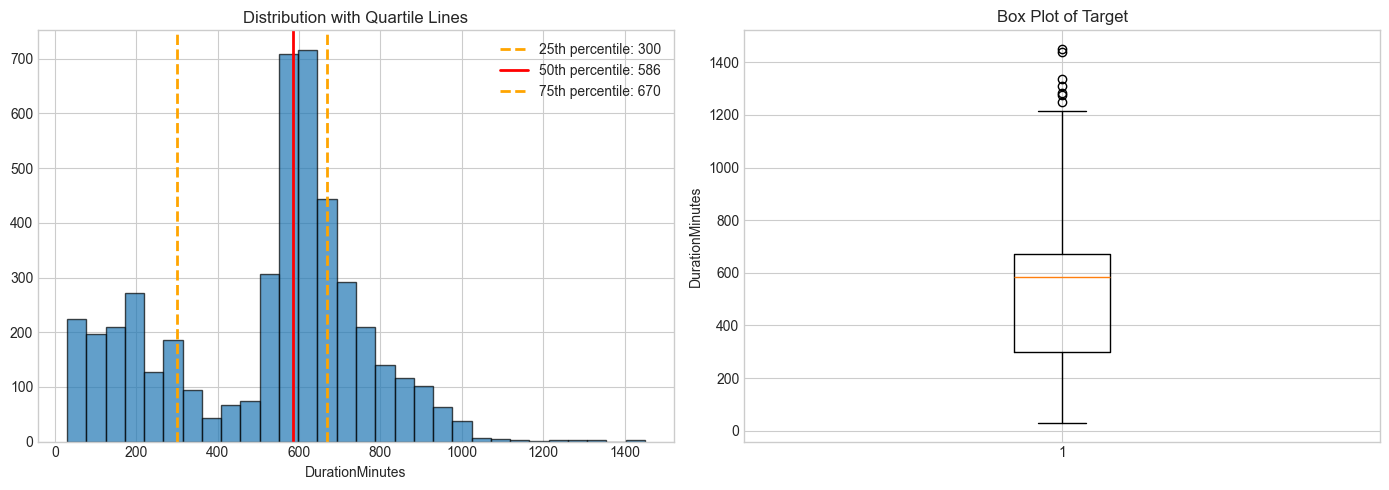

In [94]:
# Visualize potential binning strategies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with quartile lines
axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7)
for p, color, style in [(25, 'orange', '--'), (50, 'red', '-'), (75, 'orange', '--')]:
    axes[0].axvline(y.quantile(p/100), color=color, linestyle=style, linewidth=2,
                     label=f'{p}th percentile: {y.quantile(p/100):,.0f}')
axes[0].set_xlabel(TARGET)
axes[0].set_title('Distribution with Quartile Lines')
axes[0].legend()

# Box plot
axes[1].boxplot(y)
axes[1].set_ylabel(TARGET)
axes[1].set_title('Box Plot of Target')

plt.tight_layout()
plt.show()

### Proposed Binning Strategy

*Complete this section and send to Abishek on Slack by Feb 15:*

**1. How many categories will you create?**

Short trips, Medium trips, Long trips

**2. What are your bin thresholds?**

Short trips: ≤ 400 minutes
Medium trips: 400 – 800 minutes
Long trips: > 800 minutes


**3. Why does this binning make sense for your problem?**

The proposed binning strategy creates three categories: Short trips, Medium trips, and Long trips. 
The thresholds are chosen based on the distribution of the target variable (DurationMinutes) to ensure that each category has a meaningful number of observations.

In [96]:
# Preview your binning
def create_bins_preview(y, strategy='quartile'):
    if strategy == 'quartile':
        bins = [y.min()-1, y.quantile(0.25), y.quantile(0.75), y.max()+1]
        labels = ['Low', 'Medium', 'High']
    elif strategy == 'tertile':
        bins = [y.min()-1, y.quantile(0.33), y.quantile(0.67), y.max()+1]
        labels = ['Low', 'Medium', 'High']
    # Add your custom strategy here if needed
    elif strategy == 'custom':
        bins = [y.min()-1, 400, 800, y.max()+1]
        labels = ['Short', 'Medium', 'Long']
    
    return pd.cut(y, bins=bins, labels=labels)

# Preview with quartile binning
y_binned = create_bins_preview(y, 'quartile')
print("Preview of binned target (using quartiles):")
print(y_binned.value_counts().sort_index())
print(f"\nPercentages:")
print((y_binned.value_counts(normalize=True) * 100).round(1).sort_index())



Preview of binned target (using quartiles):
DurationMinutes
Low       1178
Medium    2313
High      1160
Name: count, dtype: int64

Percentages:
DurationMinutes
Low       25.3
Medium    49.7
High      24.9
Name: proportion, dtype: float64


---

## Summary

### What You Accomplished
- [ ] Loaded and prepared cleaned data
- [ ] Split data into train and test sets
- [ ] Scaled features appropriately
- [ ] Built a baseline model
- [ ] Tried multiple model types
- [ ] Performed cross-validation
- [ ] Selected top 4-8 features
- [ ] Compared and selected best model
- [ ] Analyzed model performance (residuals, feature importance)
- [ ] Saved model, scaler, and feature list
- [ ] Planned binning strategy for classification

### Key Results

**Best Model:** GradientBoostingRegressor

**Selected Features:** ['RouteIndex', 'Direction_encoded', 'DraftNumeric', 'Propulsion_encoded', 'WL_Annapolis_MD', 'WL_CBBT_Chesapeake_Channel_VA', 'CUR_York_Spit_LB_22_direction', 'WL_Annapolis_MD_speed']

**Test R²:** 0.9087

**Test RMSE:** 72.50

**Improvement over baseline:** Significant improvement in R² from ~0.29 to ~0.91 and a substantial reduction in RMSE from ~200 to ~72.50, indicating that the GradientBoostingRegressor captures the underlying patterns in the data much better than the baseline Linear Regression model.

---

---

## Checkpoint 3 Submission Instructions

**Congratulations!** You've completed Checkpoint 3 (Regression Model).

### Step 1: Save This Notebook
- File -> Save (or Ctrl+S / Cmd+S)

### Step 2: Send Binning Strategy to Abishek
- Message Abishek on Slack with your binning strategy
- Include: number of categories, thresholds, and justification

### Step 3: Commit to GitHub

```bash
# Stage your changes
git add notebooks/02_regression_model.ipynb
git add models/

# Commit with a meaningful message
git commit -m "Complete Checkpoint 3: Regression model with feature selection"

# Push to GitHub
git push
```

### Step 4: Submit to Canvas
1. Go to the Checkpoint 3 assignment on Canvas
2. Submit the link to your GitHub repository

---

## Next Steps

1. **Wait for binning approval** from Abishek
2. Move on to **Notebook 03: Classification Model**

---